Tests to implement:

1. KDD/GDD biases
2. LH/SH biases
3. Do these biases scale with ag production
4. Do these biases change over the growing season
5. Do historical cmip6 temperature biases predict future changes

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import cartopy
import cartopy.util
import cartopy.crs as ccrs
import glob
import sys, os
import pickle, gzip
import datetime
import rasterio as rio
from scipy import interpolate

In [2]:
run ../util/setupConsole_su

In [3]:
dirCmip6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirERA5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirERA5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirDeepak = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate/deepak'
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirProj = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'


In [4]:
# files = glob.glob('%s/monthly/transpiration_new_monthly_*.nc'%dirERA5Land)
# for f in files:
#     os.rename(f,'%s/monthly/transpiration_%s.nc'%(dirERA5Land,f[-7:-3])) 

In [5]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)

In [6]:
cmip6_models = ['access-cm2', 'access-esm1-5', 'awi-cm-1-1-mr', 'bcc-csm2-mr', 'bcc-esm1', 'canesm5', 'ec-earth3', \
                'gfdl-cm4', 'gfdl-esm4', 'giss-e2-1-g', 'kace-1-0-g', 'fgoals-g3', 'inm-cm5-0', 'ipsl-cm6a-lr', 'miroc6', \
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr', 'mri-esm2-0', 'noresm2-lm', 'noresm2-mm', 'sam0-unicon']

In [7]:
region = 'global'
crop = 'Maize'

if region == 'global':
    latRange = [-90, 90]
    lonRange = [0, 360]
elif region == 'us':
    latRange = [20, 57]
    lonRange = [220, 300]
elif region == 'china':
    latRange = [25, 45]
    lonRange = [105, 123]
elif region == 'eu':
    latRange = [38, 56]
    lonRange = [-5, 40]

latIndRange_era5 = np.where((era5_lat >= latRange[0]) & (era5_lat <= latRange[1]))[0]
lonIndRange_era5 = np.where((era5_lon >= lonRange[0]) & (era5_lon <= lonRange[1]))[0]

regridMesh_current = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], 1.5)),
                            'lon': (['lon'], np.arange(lonRange[0], lonRange[1], 1.5)),})

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})


if region == 'global':
    regridMesh = regridMesh_global
else:
    regridMesh = regridMesh_current

In [8]:
rebuild = False
if rebuild:
    crop_pasterland_dir = '%s/CroplandPastureArea2000_Geotiff/CroplandPastureArea2000_Geotiff'%dirAgData
    pastureData = rio.open('%s/Pasture2000_5m.tif'%crop_pasterland_dir)
    pastureData = pasture.read(1)

    cropData = rio.open('%s/Cropland2000_5m.tif'%crop_pasterland_dir)
    cropData = cropData.read(1)

    latOld = np.linspace(pasture.bounds.bottom, pasture.bounds.top, pasture.shape[0])
    lonOld = np.linspace(pasture.bounds.left, pasture.bounds.right, pasture.shape[1])
    lonOld[lonOld<0] += 360

    pastureInterp = interpolate.interp2d(lonOld, latOld, pastureData, kind='linear')
    cropInterp = interpolate.interp2d(lonOld, latOld, cropData, kind='linear')

    latNew = regridMesh['lat']
    lonNew = np.roll(regridMesh['lon'], int(regridMesh['lon'].size/2))

    pastureRegrid = pastureInterp(lonNew, latNew)
    pastureRegrid[pastureRegrid < 0] = np.nan
    pastureRegrid = np.flipud(pastureRegrid)
    # pastureRegrid = np.roll(pastureRegrid, int(pastureRegrid.shape[1]/2), axis=1)

    cropRegrid = cropInterp(lonNew, latNew)
    cropRegrid[cropRegrid < 0] = np.nan
    cropRegrid = np.flipud(cropRegrid)
    # cropRegrid = np.roll(cropRegrid, int(cropRegrid.shape[1]/2), axis=1)

    with open('cropped_area/crop_land_regrid.dat', 'wb') as f:
        pickle.dump(cropRegrid, f)
    with open('cropped_area/pasture_land_regrid.dat', 'wb') as f:
        pickle.dump(pastureRegrid, f)

In [9]:
rebuild = False

if rebuild:
    for m, model in enumerate(cmip6_models):
        print('loading %s'%model)

        if os.path.isfile('cmip6_output/cmip6_tasmax_max_%s_regrid_%s.nc'%(region, cmip6_models[m])):
            print('skipping %s, exists'%cmip6_models[m])
            continue

        if not os.path.isfile('cmip6_output/cmip6_tasmax_max_global_%s.nc'%(cmip6_models[m])):
            print('skipping %s, base file DOESNT EXIST'%cmip6_models[m])
            continue

        ds_global_txx = xr.open_dataset('cmip6_output/cmip6_tasmax_max_global_%s.nc'%cmip6_models[m])
        ds_global_monthly_txx = xr.open_dataset('cmip6_output/cmip6_tasmax_monthly_max_global_%s.nc'%cmip6_models[m])
        ds_global_t50p = xr.open_dataset('cmip6_output/cmip6_tasmax_mean_global_%s.nc'%cmip6_models[m])
        
        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_txx.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_txx.tasmax_max)

        da_global_txx_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_txx.time, 'lat':ds_global_txx.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })
        ds_global_txx_cyc = xr.Dataset()
        ds_global_txx_cyc['tasmax_max'] = da_global_txx_cyc
        
        regridder = xe.Regridder(ds_global_txx_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_txx = regridder(ds_global_txx_cyc)

        
        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_monthly_txx.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_monthly_txx.tasmax_monthly_max)

        da_global_monthly_txx_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_monthly_txx.time, 'lat':ds_global_monthly_txx.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })
        ds_global_monthly_txx_cyc = xr.Dataset()
        ds_global_monthly_txx_cyc['tasmax_monthly_max'] = da_global_monthly_txx_cyc
        
        regridder = xe.Regridder(ds_global_monthly_txx_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_monthly_txx = regridder(ds_global_monthly_txx_cyc)

        
        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_t50p.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_t50p.tasmax_mean)

        da_global_t50p_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_t50p.time, 'lat':ds_global_t50p.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })
        ds_global_t50p_cyc = xr.Dataset()
        ds_global_t50p_cyc['tasmax_mean'] = da_global_t50p_cyc
        
        regridder = xe.Regridder(ds_global_t50p_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_t50p = regridder(ds_global_t50p_cyc)
        
        cmip6_tasmax_max = ds_global_txx.assign_coords({'model':model})
        cmip6_tasmax_monthly_max = ds_global_monthly_txx.assign_coords({'model':model})
        cmip6_tasmax_mean = ds_global_t50p.assign_coords({'model':model})

        cmip6_tasmax_max.to_netcdf('cmip6_output/cmip6_tasmax_max_regrid_%s_%s.nc'%(region, model))
        cmip6_tasmax_monthly_max.to_netcdf('cmip6_output/cmip6_tasmax_monthly_max_regrid_%s_%s.nc'%(region, model))
        cmip6_tasmax_mean.to_netcdf('cmip6_output/cmip6_tasmax_mean_regrid_%s_%s.nc'%(region, model))


In [10]:

rebuild_temp = False
rebuild_ef = False
rebuild_mrso = False
rebuild_pr = False
rebuild_tran = False
rebuild_evspsblveg = False
rebuild_evspsblsoi = True
rebuild_cropFrac = False

for m, model in enumerate(cmip6_models):

    if rebuild_temp:
        print('loading temp %s'%model)

#         if os.path.isfile('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model)):
#             print('skipping %s, exists'%cmip6_models[m])
#             continue

        if not os.path.isfile('cmip6_output/growing_season/cmip6_Maize_grow_tasmax_max_global_%s.nc'%model):
            print('skipping %s, base file DOESNT EXIST'%model)
            continue

        ds_global_tmax = xr.open_dataset('cmip6_output/growing_season/cmip6_Maize_grow_tasmax_max_global_%s.nc'%model)
        ds_global_tmean = xr.open_dataset('cmip6_output/growing_season/cmip6_Maize_grow_tasmax_mean_global_%s.nc'%model)

        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_tmax.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_tmax.tasmax_grow_max)

        da_global_tasmax_grow_tmax_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_tmax.time, 'lat':ds_global_tmax.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })

        ds_global_tasmax_grow_tmax_cyc = xr.Dataset()
        ds_global_tasmax_grow_tmax_cyc['tasmax_grow_max'] = da_global_tasmax_grow_tmax_cyc

        regridder = xe.Regridder(ds_global_tasmax_grow_tmax_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_tasmax_grow_tmax_cyc_regrid = regridder(ds_global_tasmax_grow_tmax_cyc)



        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_tmean.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_tmean.tasmax_grow_mean)

        da_global_tasmax_grow_tmean_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_tmean.time, 'lat':ds_global_tmean.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })

        ds_global_tasmax_grow_tmean_cyc = xr.Dataset()
        ds_global_tasmax_grow_tmean_cyc['tasmax_grow_mean'] = da_global_tasmax_grow_tmean_cyc

        regridder = xe.Regridder(ds_global_tasmax_grow_tmean_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_tasmax_grow_tmean_cyc_regrid = regridder(ds_global_tasmax_grow_tmean_cyc)

        ds_global_tasmax_grow_tmax_cyc_regrid = ds_global_tasmax_grow_tmax_cyc_regrid.assign_coords({'model':model})
        ds_global_tasmax_grow_tmean_cyc_regrid = ds_global_tasmax_grow_tmean_cyc_regrid.assign_coords({'model':model})

        ds_global_tasmax_grow_tmax_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model))
        ds_global_tasmax_grow_tmean_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_tasmax_grow_mean_%s_%s_regrid.nc'%(crop, region, model))

    if rebuild_ef:
        if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s.nc'%(crop, model)):
            print('loading ef for %s'%model)
            ds_global_ef = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s.nc'%(crop, model))

            # add cyclic point before regridding
            lon_data = cartopy.util.add_cyclic_point(ds_global_ef.lon)
            ef_data = cartopy.util.add_cyclic_point(ds_global_ef.grow_ef)

            da_global_ef_grow_cyc = xr.DataArray(data   = ef_data, 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':ds_global_ef.time, 'lat':ds_global_ef.lat, 'lon':lon_data},
                              attrs  = {'units'     : 'Fraction'
                                })

            ds_global_ef_grow_cyc = xr.Dataset()
            ds_global_ef_grow_cyc['grow_ef'] = da_global_ef_grow_cyc

            regridder = xe.Regridder(ds_global_ef_grow_cyc, regridMesh, 'bilinear', reuse_weights=True)
            regridder.clean_weight_file()
            ds_global_ef_grow_cyc_regrid = regridder(ds_global_ef_grow_cyc)

            ds_global_ef_grow_cyc_regrid = ds_global_ef_grow_cyc_regrid.assign_coords({'model':model})
            ds_global_ef_grow_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s_regrid.nc'%(crop, model))

        else:
            print('skipping ef %s, doesn\'t exists'%cmip6_models[m])
            
            
    # MRSO
    if rebuild_mrso:
        if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s.nc'%(crop, model)):
            print('loading mrso for %s'%model)
            ds_global_mrso = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s.nc'%(crop, model))

            # add cyclic point before regridding
            lon_data = cartopy.util.add_cyclic_point(ds_global_mrso.lon)
            mrso_data = cartopy.util.add_cyclic_point(ds_global_mrso.grow_mrso)

            da_global_mrso_grow_cyc = xr.DataArray(data   = mrso_data, 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':ds_global_mrso.time, 'lat':ds_global_mrso.lat, 'lon':lon_data},
                              attrs  = {'units'     : 'mm'
                                })

            ds_global_mrso_grow_cyc = xr.Dataset()
            ds_global_mrso_grow_cyc['grow_mrso'] = da_global_mrso_grow_cyc

            regridder = xe.Regridder(ds_global_mrso_grow_cyc, regridMesh, 'bilinear', reuse_weights=True)
            regridder.clean_weight_file()
            ds_global_mrso_grow_cyc_regrid = regridder(ds_global_mrso_grow_cyc)

            ds_global_mrso_grow_cyc_regrid = ds_global_mrso_grow_cyc_regrid.assign_coords({'model':model})
            ds_global_mrso_grow_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s_regrid.nc'%(crop, model))

        else:
            print('skipping mrso %s, doesn\'t exists'%cmip6_models[m])
            
            
            
    # CROP FRAC
    if rebuild_cropFrac:
        if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s.nc'%(crop, model)):
            print('loading cropFrac for %s'%model)
            ds_global_cropFrac = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s.nc'%(crop, model))

            # add cyclic point before regridding
            lon_data = cartopy.util.add_cyclic_point(ds_global_cropFrac.lon)
            cropFrac_data = cartopy.util.add_cyclic_point(ds_global_cropFrac.grow_cropFrac)

            da_global_cropFrac_grow_cyc = xr.DataArray(data   = cropFrac_data, 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':ds_global_cropFrac.time, 'lat':ds_global_cropFrac.lat, 'lon':lon_data},
                              attrs  = {'units'     : 'mm'
                                })

            ds_global_cropFrac_grow_cyc = xr.Dataset()
            ds_global_cropFrac_grow_cyc['grow_cropFrac'] = da_global_cropFrac_grow_cyc

            regridder = xe.Regridder(ds_global_cropFrac_grow_cyc, regridMesh, 'bilinear', reuse_weights=True)
            regridder.clean_weight_file()
            ds_global_cropFrac_grow_cyc_regrid = regridder(ds_global_cropFrac_grow_cyc)

            ds_global_cropFrac_grow_cyc_regrid = ds_global_cropFrac_grow_cyc_regrid.assign_coords({'model':model})
            ds_global_cropFrac_grow_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid.nc'%(crop, model))

        else:
            print('skipping cropFrac %s, doesn\'t exists'%cmip6_models[m])




    # PRECIP
    if rebuild_pr:
        if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s.nc'%(crop, model)):
            print('loading pr for %s'%model)
            ds_global_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s.nc'%(crop, model))

            # add cyclic point before regridding
            lon_data = cartopy.util.add_cyclic_point(ds_global_pr.lon)
            pr_data = cartopy.util.add_cyclic_point(ds_global_pr.pr_grow_mean)

            da_global_grow_pr_cyc = xr.DataArray(data   = pr_data, 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':ds_global_pr.time, 'lat':ds_global_pr.lat, 'lon':lon_data},
                              attrs  = {'units'     : 'mm'
                                })

            ds_global_grow_pr_cyc = xr.Dataset()
            ds_global_grow_pr_cyc['pr_grow_mean'] = da_global_grow_pr_cyc

            regridder = xe.Regridder(da_global_grow_pr_cyc, regridMesh, 'bilinear', reuse_weights=True)
            regridder.clean_weight_file()
            ds_global_grow_pr_cyc_regrid = regridder(ds_global_grow_pr_cyc)

            ds_global_grow_pr_cyc_regrid = ds_global_grow_pr_cyc_regrid.assign_coords({'model':model})
            ds_global_grow_pr_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid.nc'%(crop, model))

        else:
            print('skipping pr %s, doesn\'t exists'%cmip6_models[m])
            
            
            
    # TRAN
    if rebuild_tran:
        if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s.nc'%(crop, model)):
            print('loading tran for %s'%model)
            ds_global_tran = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s.nc'%(crop, model))

            # add cyclic point before regridding
            lon_data = cartopy.util.add_cyclic_point(ds_global_tran.lon)
            tran_data = cartopy.util.add_cyclic_point(ds_global_tran.grow_tran)

            da_global_grow_tran_cyc = xr.DataArray(data   = tran_data, 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':ds_global_tran.time, 'lat':ds_global_tran.lat, 'lon':lon_data},
                              attrs  = {'units'     : 'mm'
                                })

            ds_global_grow_tran_cyc = xr.Dataset()
            ds_global_grow_tran_cyc['tran_grow_mean'] = da_global_grow_tran_cyc

            regridder = xe.Regridder(da_global_grow_tran_cyc, regridMesh, 'bilinear', reuse_weights=True)
            regridder.clean_weight_file()
            ds_global_grow_tran_cyc_regrid = regridder(ds_global_grow_tran_cyc)

            ds_global_grow_tran_cyc_regrid = ds_global_grow_tran_cyc_regrid.assign_coords({'model':model})
            ds_global_grow_tran_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid.nc'%(crop, model))

        else:
            print('skipping tran %s, doesn\'t exists'%cmip6_models[m])
        
        
    # EVAP FROM CANOPY
    if rebuild_evspsblveg:
        if os.path.isfile('cmip6_output/growing_season/cmip6_evspsblveg_grow_%s_mon_global_%s.nc'%(crop, model)):
            print('loading evspsblveg for %s'%model)
            ds_global_evspsblveg = xr.open_dataset('cmip6_output/growing_season/cmip6_evspsblveg_grow_%s_mon_global_%s.nc'%(crop, model))

            # add cyclic point before regridding
            lon_data = cartopy.util.add_cyclic_point(ds_global_evspsblveg.lon)
            evspsblveg_data = cartopy.util.add_cyclic_point(ds_global_evspsblveg.grow_evap)

            da_global_grow_evspsblveg_cyc = xr.DataArray(data   = evspsblveg_data, 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':ds_global_evspsblveg.time, 'lat':ds_global_evspsblveg.lat, 'lon':lon_data},
                              attrs  = {'units'     : 'mm'
                                })

            ds_global_grow_evspsblveg_cyc = xr.Dataset()
            ds_global_grow_evspsblveg_cyc['evspsblveg_grow_mean'] = da_global_grow_evspsblveg_cyc

            regridder = xe.Regridder(da_global_grow_evspsblveg_cyc, regridMesh, 'bilinear', reuse_weights=True)
            regridder.clean_weight_file()
            ds_global_grow_evspsblveg_cyc_regrid = regridder(ds_global_grow_evspsblveg_cyc)

            ds_global_grow_evspsblveg_cyc_regrid = ds_global_grow_evspsblveg_cyc_regrid.assign_coords({'model':model})
            ds_global_grow_evspsblveg_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid.nc'%(crop, model))

        else:
            print('skipping evspsblveg %s, doesn\'t exists'%cmip6_models[m])
        
        
    # EVAP FROM SOIL
    if rebuild_evspsblsoi:
        if os.path.isfile('cmip6_output/growing_season/cmip6_evspsblsoi_grow_%s_mon_global_%s.nc'%(crop, model)):
            print('loading evspsblsoi for %s'%model)
            ds_global_evspsblsoi = xr.open_dataset('cmip6_output/growing_season/cmip6_evspsblsoi_grow_%s_mon_global_%s.nc'%(crop, model))

            # add cyclic point before regridding
            lon_data = cartopy.util.add_cyclic_point(ds_global_evspsblsoi.lon)
            evspsblsoi_data = cartopy.util.add_cyclic_point(ds_global_evspsblsoi.grow_evap)

            da_global_grow_evspsblsoi_cyc = xr.DataArray(data   = evspsblsoi_data, 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':ds_global_evspsblsoi.time, 'lat':ds_global_evspsblsoi.lat, 'lon':lon_data},
                              attrs  = {'units'     : 'mm'
                                })

            ds_global_grow_evspsblsoi_cyc = xr.Dataset()
            ds_global_grow_evspsblsoi_cyc['evspsblsoi_grow_mean'] = da_global_grow_evspsblsoi_cyc

            regridder = xe.Regridder(da_global_grow_evspsblsoi_cyc, regridMesh, 'bilinear', reuse_weights=True)
            regridder.clean_weight_file()
            ds_global_grow_evspsblsoi_cyc_regrid = regridder(ds_global_grow_evspsblsoi_cyc)

            ds_global_grow_evspsblsoi_cyc_regrid = ds_global_grow_evspsblsoi_cyc_regrid.assign_coords({'model':model})
            ds_global_grow_evspsblsoi_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid.nc'%(crop, model))

        else:
            print('skipping evspsblsoi %s, doesn\'t exists'%cmip6_models[m])
        
        



skipping evspsblsoi access-cm2, doesn't exists
loading evspsblsoi for access-esm1-5
Create weight file: bilinear_145x193_120x240.nc
Remove file bilinear_145x193_120x240.nc
using dimensions ('lat', 'lon') from data variable evspsblsoi_grow_mean as the horizontal dimensions for this dataset.
skipping evspsblsoi awi-cm-1-1-mr, doesn't exists
loading evspsblsoi for bcc-csm2-mr
Create weight file: bilinear_160x321_120x240.nc
Remove file bilinear_160x321_120x240.nc
using dimensions ('lat', 'lon') from data variable evspsblsoi_grow_mean as the horizontal dimensions for this dataset.
loading evspsblsoi for bcc-esm1
Create weight file: bilinear_64x129_120x240.nc
Remove file bilinear_64x129_120x240.nc
using dimensions ('lat', 'lon') from data variable evspsblsoi_grow_mean as the horizontal dimensions for this dataset.
loading evspsblsoi for canesm5
Create weight file: bilinear_64x129_120x240.nc
Remove file bilinear_64x129_120x240.nc
using dimensions ('lat', 'lon') from data variable evspsblsoi_g

In [9]:
# FUTURE DATA

rebuild_temp = False
rebuild_pr = True

for m, model in enumerate(cmip6_models):

    if rebuild_temp:
        print('loading temp %s'%model)

        if not os.path.isfile('cmip6_output/growing_season/cmip6_Maize_grow_ssp245_tasmax_max_global_%s.nc'%model):
            print('skipping %s, base file DOESNT EXIST'%model)
            continue

        ds_global_tmax = xr.open_dataset('cmip6_output/growing_season/cmip6_Maize_grow_ssp245_tasmax_max_global_%s.nc'%model)
        ds_global_tmean = xr.open_dataset('cmip6_output/growing_season/cmip6_Maize_grow_ssp245_tasmax_mean_global_%s.nc'%model)

        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_tmax.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_tmax.tasmax_grow_max)

        da_global_tasmax_grow_tmax_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_tmax.time, 'lat':ds_global_tmax.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })

        ds_global_tasmax_grow_tmax_cyc = xr.Dataset()
        ds_global_tasmax_grow_tmax_cyc['tasmax_grow_max'] = da_global_tasmax_grow_tmax_cyc

        regridder = xe.Regridder(ds_global_tasmax_grow_tmax_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_tasmax_grow_tmax_cyc_regrid = regridder(ds_global_tasmax_grow_tmax_cyc)



        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_tmean.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_tmean.tasmax_grow_mean)

        da_global_tasmax_grow_tmean_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_tmean.time, 'lat':ds_global_tmean.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })

        ds_global_tasmax_grow_tmean_cyc = xr.Dataset()
        ds_global_tasmax_grow_tmean_cyc['tasmax_grow_mean'] = da_global_tasmax_grow_tmean_cyc

        regridder = xe.Regridder(ds_global_tasmax_grow_tmean_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_tasmax_grow_tmean_cyc_regrid = regridder(ds_global_tasmax_grow_tmean_cyc)

        ds_global_tasmax_grow_tmax_cyc_regrid = ds_global_tasmax_grow_tmax_cyc_regrid.assign_coords({'model':model})
        ds_global_tasmax_grow_tmean_cyc_regrid = ds_global_tasmax_grow_tmean_cyc_regrid.assign_coords({'model':model})

        ds_global_tasmax_grow_tmax_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_max_%s_%s_regrid.nc'%(crop, region, model))
        ds_global_tasmax_grow_tmean_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model))
        
        
        
        
    if rebuild_pr:
        print('loading pr %s'%model)

        if not os.path.isfile('cmip6_output/growing_season/cmip6_Maize_grow_ssp245_pr_mean_global_%s.nc'%model):
            print('skipping %s, base file DOESNT EXIST'%model)
            continue

        ds_global_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_Maize_grow_ssp245_pr_mean_global_%s.nc'%model)

        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_pr.lon)
        pr_data = cartopy.util.add_cyclic_point(ds_global_pr.pr_grow_mean)

        da_global_pr_grow_cyc = xr.DataArray(data   = pr_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_pr.time, 'lat':ds_global_pr.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'mm'
                            })

        ds_global_pr_grow_cyc = xr.Dataset()
        ds_global_pr_grow_cyc['pr_grow_mean'] = da_global_pr_grow_cyc

        regridder = xe.Regridder(ds_global_pr_grow_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_pr_grow_cyc_regrid = regridder(ds_global_pr_grow_cyc)

        ds_global_pr_grow_cyc_regrid = ds_global_pr_grow_cyc_regrid.assign_coords({'model':model})
        ds_global_pr_grow_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_pr_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model))




loading pr access-cm2
Create weight file: bilinear_144x193_120x240.nc
Remove file bilinear_144x193_120x240.nc
using dimensions ('lat', 'lon') from data variable pr_grow_mean as the horizontal dimensions for this dataset.
loading pr access-esm1-5
Create weight file: bilinear_145x193_120x240.nc
Remove file bilinear_145x193_120x240.nc
using dimensions ('lat', 'lon') from data variable pr_grow_mean as the horizontal dimensions for this dataset.
loading pr awi-cm-1-1-mr
Create weight file: bilinear_192x385_120x240.nc
Remove file bilinear_192x385_120x240.nc
using dimensions ('lat', 'lon') from data variable pr_grow_mean as the horizontal dimensions for this dataset.
loading pr bcc-csm2-mr
Create weight file: bilinear_160x321_120x240.nc
Remove file bilinear_160x321_120x240.nc
using dimensions ('lat', 'lon') from data variable pr_grow_mean as the horizontal dimensions for this dataset.
loading pr bcc-esm1
skipping bcc-esm1, base file DOESNT EXIST
loading pr canesm5
Create weight file: bilinear

In [11]:
cmip6_tasmax_grow_max = xr.Dataset()
cmip6_tasmax_grow_mean = xr.Dataset()
cmip6_ef_grow = xr.Dataset()
cmip6_mrso_grow = xr.Dataset()
cmip6_pr_grow = xr.Dataset()
cmip6_tran_grow = xr.Dataset()
cmip6_evspsblveg_grow = xr.Dataset()
cmip6_evspsblsoi_grow = xr.Dataset()
cmip6_cropFrac_grow = xr.Dataset()

ef_m = 0
mrso_m = 0
pr_m = 0
tran_m = 0
evspsblveg_m = 0
evspsblsoi_m = 0
cropFrac_m = 0

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model)):
        print('skipping tasmax max %s'%model)
        
        continue
    
#     print('loading regridded growing season tasmax for %s'%model)

    ds_global_txx = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model))
    ds_global_t50p = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_mean_%s_%s_regrid.nc'%(crop, region, model))
    
    if m == 0:
        cmip6_tasmax_grow_max = ds_global_txx
        cmip6_tasmax_grow_mean = ds_global_t50p
    else:
        cmip6_tasmax_grow_max = xr.concat([cmip6_tasmax_grow_max, ds_global_txx], dim='model')
        cmip6_tasmax_grow_mean = xr.concat([cmip6_tasmax_grow_mean, ds_global_t50p], dim='model')
    
    
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_ef = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s_regrid.nc'%(crop, model))
        
        if ef_m == 0:
            cmip6_ef_grow = ds_global_ef
        else:
            cmip6_ef_grow = xr.concat([cmip6_ef_grow, ds_global_ef], dim='model')
        ef_m += 1
    else:
        print('skipping ef %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_mrso = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s_regrid.nc'%(crop, model))
        
        if mrso_m == 0:
            cmip6_mrso_grow = ds_global_mrso
        else:
            cmip6_mrso_grow = xr.concat([cmip6_mrso_grow, ds_global_mrso], dim='model')
        mrso_m += 1
    else:
        print('skipping mrso %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid.nc'%(crop, model)):
        ds_global_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid.nc'%(crop, model))
        
        if pr_m == 0:
            cmip6_pr_grow = ds_global_pr
        else:
            cmip6_pr_grow = xr.concat([cmip6_pr_grow, ds_global_pr], dim='model')
        pr_m += 1
    else:
        print('skipping pr %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_tran = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid.nc'%(crop, model))
        
        if tran_m == 0:
            cmip6_tran_grow = ds_global_tran
        else:
            cmip6_tran_grow = xr.concat([cmip6_tran_grow, ds_global_tran], dim='model')
        tran_m += 1
    else:
        print('skipping tran %s'%model)
        
    
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_evspsblveg = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid.nc'%(crop, model))
        
        if evspsblveg_m == 0:
            cmip6_evspsblveg_grow = ds_global_evspsblveg
        else:
            cmip6_evspsblveg_grow = xr.concat([cmip6_evspsblveg_grow, ds_global_evspsblveg], dim='model')
        evspsblveg_m += 1
    else:
        print('skipping evspsblveg %s'%model)
        
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_evspsblsoi = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid.nc'%(crop, model))
        
        if evspsblsoi_m == 0:
            cmip6_evspsblsoi_grow = ds_global_evspsblsoi
        else:
            cmip6_evspsblsoi_grow = xr.concat([cmip6_evspsblsoi_grow, ds_global_evspsblsoi], dim='model')
        evspsblsoi_m += 1
    else:
        print('skipping evspsblsoi %s'%model)
    
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_cropFrac = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid.nc'%(crop, model))
        
        if cropFrac_m == 0:
            cmip6_cropFrac_grow = ds_global_cropFrac
        else:
            cmip6_cropFrac_grow = xr.concat([cmip6_cropFrac_grow, ds_global_cropFrac], dim='model')
        cropFrac_m += 1
    else:
        print('skipping cropFrac %s'%model)


skipping tran access-cm2
skipping evspsblveg access-cm2
skipping evspsblsoi access-cm2
skipping tran access-esm1-5
skipping evspsblveg access-esm1-5
skipping mrso awi-cm-1-1-mr
skipping pr awi-cm-1-1-mr
skipping tran awi-cm-1-1-mr
skipping evspsblveg awi-cm-1-1-mr
skipping evspsblsoi awi-cm-1-1-mr
skipping cropFrac awi-cm-1-1-mr
skipping pr bcc-csm2-mr
skipping cropFrac bcc-csm2-mr
skipping cropFrac bcc-esm1
skipping tran ec-earth3
skipping evspsblveg ec-earth3
skipping evspsblsoi ec-earth3
skipping cropFrac ec-earth3
skipping ef gfdl-cm4
skipping pr gfdl-cm4
skipping evspsblveg gfdl-cm4
skipping evspsblsoi gfdl-cm4
skipping ef gfdl-esm4
skipping evspsblveg gfdl-esm4
skipping evspsblsoi gfdl-esm4
skipping mrso giss-e2-1-g
skipping pr giss-e2-1-g
skipping evspsblveg giss-e2-1-g
skipping evspsblsoi giss-e2-1-g
skipping cropFrac giss-e2-1-g
skipping ef kace-1-0-g
skipping mrso kace-1-0-g
skipping tran kace-1-0-g
skipping cropFrac kace-1-0-g
skipping evspsblveg fgoals-g3
skipping evspsblso

In [13]:
# LOAD FUTURE DATA

cmip6_tasmax_grow_max_ssp245 = xr.Dataset()

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_max_%s_%s_regrid.nc'%(crop, region, model)):
        print('skipping tasmax max %s'%model)
        
        continue
    
#     print('loading regridded growing season tasmax for %s'%model)

    ds_global_txx = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_max_%s_%s_regrid.nc'%(crop, region, model))
    ds_global_t50p = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model))
    
    if m == 0:
        cmip6_tasmax_grow_max_ssp245 = ds_global_txx
        cmip6_tasmax_grow_mean_ssp245 = ds_global_t50p
    else:
        cmip6_tasmax_grow_max_ssp245 = xr.concat([cmip6_tasmax_grow_max_ssp245, ds_global_txx], dim='model')
        cmip6_tasmax_grow_mean_ssp245 = xr.concat([cmip6_tasmax_grow_mean_ssp245, ds_global_t50p], dim='model')

skipping tasmax max awi-cm-1-1-mr
skipping tasmax max bcc-esm1
skipping tasmax max gfdl-cm4
skipping tasmax max gfdl-esm4
skipping tasmax max giss-e2-1-g
skipping tasmax max kace-1-0-g
skipping tasmax max fgoals-g3
skipping tasmax max inm-cm5-0
skipping tasmax max mpi-esm1-2-hr
skipping tasmax max mpi-esm1-2-lr
skipping tasmax max sam0-unicon


In [11]:
cmip6_tasmax_max = xr.Dataset()
cmip6_tasmax_monthly_max = xr.Dataset()
cmip6_tasmax_mean = xr.Dataset()

for m, model in enumerate(cmip6_models):

    print('loading regridded tasmax for %s'%model)

    ds_global_txx = xr.open_dataset('cmip6_output/cmip6_tasmax_max_regrid_%s_%s.nc'%(region, model))
    ds_global_monthly_tx = xr.open_dataset('cmip6_output/cmip6_tasmax_monthly_max_regrid_%s_%s.nc'%(region, model))
    ds_global_t50p = xr.open_dataset('cmip6_output/cmip6_tasmax_mean_regrid_%s_%s.nc'%(region, model))

    if m == 0:
        cmip6_tasmax_max = ds_global_txx
        cmip6_tasmax_monthly_max = ds_global_monthly_tx
        cmip6_tasmax_mean = ds_global_t50p
    else:
        cmip6_tasmax_max = xr.concat([cmip6_tasmax_max, ds_global_txx], dim='model')
        cmip6_tasmax_monthly_max = xr.concat([cmip6_tasmax_monthly_max, ds_global_monthly_tx], dim='model')
        cmip6_tasmax_mean = xr.concat([cmip6_tasmax_mean, ds_global_t50p], dim='model')


loading regridded tasmax for access-cm2
loading regridded tasmax for access-esm1-5
loading regridded tasmax for awi-cm-1-1-mr
loading regridded tasmax for bcc-csm2-mr
loading regridded tasmax for bcc-esm1
loading regridded tasmax for canesm5
loading regridded tasmax for ec-earth3
loading regridded tasmax for gfdl-cm4
loading regridded tasmax for gfdl-esm4
loading regridded tasmax for giss-e2-1-g
loading regridded tasmax for kace-1-0-g
loading regridded tasmax for fgoals-g3
loading regridded tasmax for inm-cm5-0
loading regridded tasmax for ipsl-cm6a-lr
loading regridded tasmax for miroc6
loading regridded tasmax for mpi-esm1-2-hr
loading regridded tasmax for mpi-esm1-2-lr
loading regridded tasmax for mri-esm2-0
loading regridded tasmax for noresm2-lm
loading regridded tasmax for noresm2-mm
loading regridded tasmax for sam0-unicon


In [12]:
rebuild = False


if rebuild:
    for m, model in enumerate(cmip6_models):
        print('loading %s'%model)

        if os.path.isfile('cmip6_output/cmip6_tasmin_max_%s_regrid_%s.nc'%(region, model)):
            print('skipping %s, exists'%cmip6_models[m])
            continue

        if not os.path.isfile('cmip6_output/cmip6_tasmin_max_global_%s.nc'%(model)):
            print('skipping %s, base file DOESNT EXIST'%cmip6_models[m])
            continue

        ds_global_txx = xr.open_dataset('cmip6_output/cmip6_tasmin_max_global_%s.nc'%model)
        ds_global_monthly_txx = xr.open_dataset('cmip6_output/cmip6_tasmin_monthly_max_global_%s.nc'%model)
        ds_global_t50p = xr.open_dataset('cmip6_output/cmip6_tasmin_mean_global_%s.nc'%model)

        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_txx.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_txx.tasmin_max)

        da_global_txx_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_txx.time, 'lat':ds_global_txx.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })
        ds_global_txx_cyc = xr.Dataset()
        ds_global_txx_cyc['tasmin_max'] = da_global_txx_cyc
        
        regridder = xe.Regridder(ds_global_txx_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_txx = regridder(ds_global_txx_cyc)

        
        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_monthly_txx.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_monthly_txx.tasmin_monthly_max)

        da_global_monthly_txx_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_monthly_txx.time, 'lat':ds_global_monthly_txx.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })
        ds_global_monthly_txx_cyc = xr.Dataset()
        ds_global_monthly_txx_cyc['tasmin_monthly_max'] = da_global_monthly_txx_cyc
        
        regridder = xe.Regridder(ds_global_monthly_txx_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_monthly_txx = regridder(ds_global_monthly_txx_cyc)

        
        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_t50p.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_t50p.tasmin_mean)

        da_global_t50p_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_t50p.time, 'lat':ds_global_t50p.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })
        ds_global_t50p_cyc = xr.Dataset()
        ds_global_t50p_cyc['tasmin_mean'] = da_global_t50p_cyc
        
        regridder = xe.Regridder(ds_global_t50p_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_t50p = regridder(ds_global_t50p_cyc)

        cmip6_tasmin_max = ds_global_txx.assign_coords({'model':model})
        cmip6_tasmin_monthly_max = ds_global_monthly_txx.assign_coords({'model':model})
        cmip6_tasmin_mean = ds_global_t50p.assign_coords({'model':model})

        cmip6_tasmin_max.to_netcdf('cmip6_output/cmip6_tasmin_max_regrid_%s_%s.nc'%(region, model))
        cmip6_tasmin_monthly_max.to_netcdf('cmip6_output/cmip6_tasmin_monthly_max_regrid_%s_%s.nc'%(region, model))
        cmip6_tasmin_mean.to_netcdf('cmip6_output/cmip6_tasmin_mean_regrid_%s_%s.nc'%(region, model))


In [13]:
cmip6_tasmin_max = xr.Dataset()
cmip6_tasmin_monthly_max = xr.Dataset()
cmip6_tasmin_mean = xr.Dataset()

for m, model in enumerate(cmip6_models):
    
    if not os.path.isfile('cmip6_output/cmip6_tasmin_max_regrid_%s_%s.nc'%(region, model)):
        print('skipping %s, base file DOESNT EXIST'%model)
        continue
    
    print('loading regridded tasmin for %s'%model)

    ds_global_txx = xr.open_dataset('cmip6_output/cmip6_tasmin_max_regrid_%s_%s.nc'%(region, model))
    ds_global_monthly_tx = xr.open_dataset('cmip6_output/cmip6_tasmin_monthly_max_regrid_%s_%s.nc'%(region, model))
    ds_global_t50p = xr.open_dataset('cmip6_output/cmip6_tasmin_mean_regrid_%s_%s.nc'%(region, model))

    if m == 0:
        cmip6_tasmin_max = ds_global_txx
        cmip6_tasmin_monthly_max = ds_global_monthly_tx
        cmip6_tasmin_mean = ds_global_t50p
    else:
        cmip6_tasmin_max = xr.concat([cmip6_tasmin_max, ds_global_txx], dim='model')
        cmip6_tasmin_monthly_max = xr.concat([cmip6_tasmin_monthly_max, ds_global_monthly_tx], dim='model')
        cmip6_tasmin_mean = xr.concat([cmip6_tasmin_mean, ds_global_t50p], dim='model')


loading regridded tasmin for access-cm2
loading regridded tasmin for access-esm1-5
loading regridded tasmin for awi-cm-1-1-mr
skipping bcc-csm2-mr, base file DOESNT EXIST
loading regridded tasmin for bcc-esm1
loading regridded tasmin for canesm5
loading regridded tasmin for ec-earth3
skipping gfdl-cm4, base file DOESNT EXIST
skipping gfdl-esm4, base file DOESNT EXIST
loading regridded tasmin for giss-e2-1-g
skipping kace-1-0-g, base file DOESNT EXIST
loading regridded tasmin for fgoals-g3
loading regridded tasmin for inm-cm5-0
loading regridded tasmin for ipsl-cm6a-lr
loading regridded tasmin for miroc6
loading regridded tasmin for mpi-esm1-2-hr
loading regridded tasmin for mpi-esm1-2-lr
loading regridded tasmin for mri-esm2-0
loading regridded tasmin for noresm2-lm
loading regridded tasmin for noresm2-mm
skipping sam0-unicon, base file DOESNT EXIST


In [14]:
cmip6_tasmax_max_trend = xr.Dataset()
cmip6_tasmax_monthly_max_trend = xr.Dataset()
cmip6_tasmax_mean_trend = xr.Dataset()

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/cmip6_tasmax_max_trend_regrid_%s_%s.nc'%(region, model)):
        print('skipping %s, base file DOESNT EXIST'%model)
        continue
    
    print('loading trends for %s'%model)

    ds_global_txx_trend = xr.open_dataset('cmip6_output/cmip6_tasmax_max_trend_regrid_%s_%s.nc'%(region, model))
    ds_global_monthly_tx_trend = xr.open_dataset('cmip6_output/cmip6_tasmax_monthly_max_trend_regrid_%s_%s.nc'%(region, model))
    ds_global_t50p_trend = xr.open_dataset('cmip6_output/cmip6_tasmax_mean_trend_regrid_%s_%s.nc'%(region, model))

    if m == 0:
        cmip6_tasmax_max_trend = ds_global_txx_trend
        cmip6_tasmax_monthly_max_trend = ds_global_monthly_tx_trend
        cmip6_tasmax_mean_trend = ds_global_t50p_trend
    else:
        cmip6_tasmax_max_trend = xr.concat([cmip6_tasmax_max_trend, ds_global_txx_trend], dim='model')
        cmip6_tasmax_monthly_max_trend = xr.concat([cmip6_tasmax_monthly_max_trend, ds_global_monthly_tx_trend], dim='model')
        cmip6_tasmax_mean_trend = xr.concat([cmip6_tasmax_mean_trend, ds_global_t50p_trend], dim='model')

# cmip6_tasmax_max_trend = cmip6_tasmax_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmax_monthly_max_trend = cmip6_tasmax_monthly_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmax_mean_trend = cmip6_tasmax_mean_trend.assign_coords({'model':cmip6_models})


loading trends for access-cm2
loading trends for access-esm1-5
loading trends for awi-cm-1-1-mr
loading trends for bcc-csm2-mr
loading trends for bcc-esm1
loading trends for canesm5
loading trends for ec-earth3
loading trends for gfdl-cm4
loading trends for gfdl-esm4
loading trends for giss-e2-1-g
loading trends for kace-1-0-g
loading trends for fgoals-g3
loading trends for inm-cm5-0
loading trends for ipsl-cm6a-lr
loading trends for miroc6
loading trends for mpi-esm1-2-hr
loading trends for mpi-esm1-2-lr
loading trends for mri-esm2-0
loading trends for noresm2-lm
loading trends for noresm2-mm
loading trends for sam0-unicon


In [15]:
cmip6_tasmax_grow_max_trend = xr.Dataset()
cmip6_tasmax_grow_mean_trend = xr.Dataset()
cmip6_ef_grow_trend = xr.Dataset()
cmip6_pr_grow_trend = xr.Dataset()

ef_m = 0
pr_m = 0

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_%s_grow_max_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model)):
        print('skipping %s, base file DOESNT EXIST'%model)
        continue
    
    print('loading growing season trends for %s'%model)

    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_trend_global_%s_regrid.nc'%(crop, model)):
        ds_global_ef_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_trend_global_%s_regrid.nc'%(crop, model))
        
        if ef_m == 0:
            cmip6_ef_grow_trend = ds_global_ef_trend
        else:
            cmip6_ef_grow_trend = xr.concat([cmip6_ef_grow_trend, ds_global_ef_trend], dim='model')
        ef_m += 1
    else:
        print('skipping ef %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_trend_global_%s_regrid.nc'%(crop, model)):
        ds_global_pr_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_trend_global_%s_regrid.nc'%(crop, model))
        
        if pr_m == 0:
            cmip6_pr_grow_trend = ds_global_pr_trend
        else:
            cmip6_pr_grow_trend = xr.concat([cmip6_pr_grow_trend, ds_global_pr_trend], dim='model')
        pr_m += 1
    else:
        print('skipping pr %s'%model)
    
    ds_global_txx_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_%s_grow_max_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model))
    ds_global_t50p_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_%s_grow_mean_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model))

    if m == 0:
        cmip6_tasmax_grow_max_trend = ds_global_txx_trend
        cmip6_tasmax_grow_mean_trend = ds_global_t50p_trend
    else:
        cmip6_tasmax_grow_max_trend = xr.concat([cmip6_tasmax_grow_max_trend, ds_global_txx_trend], dim='model')
        cmip6_tasmax_grow_mean_trend = xr.concat([cmip6_tasmax_grow_mean_trend, ds_global_t50p_trend], dim='model')

# cmip6_tasmax_max_trend = cmip6_tasmax_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmax_monthly_max_trend = cmip6_tasmax_monthly_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmax_mean_trend = cmip6_tasmax_mean_trend.assign_coords({'model':cmip6_models})


loading growing season trends for access-cm2
loading growing season trends for access-esm1-5
loading growing season trends for awi-cm-1-1-mr
skipping pr awi-cm-1-1-mr
loading growing season trends for bcc-csm2-mr
skipping pr bcc-csm2-mr
loading growing season trends for bcc-esm1
loading growing season trends for canesm5
loading growing season trends for ec-earth3
loading growing season trends for gfdl-cm4
skipping ef gfdl-cm4
skipping pr gfdl-cm4
loading growing season trends for gfdl-esm4
skipping ef gfdl-esm4
loading growing season trends for giss-e2-1-g
skipping pr giss-e2-1-g
loading growing season trends for kace-1-0-g
skipping ef kace-1-0-g
loading growing season trends for fgoals-g3
loading growing season trends for inm-cm5-0
loading growing season trends for ipsl-cm6a-lr
loading growing season trends for miroc6
loading growing season trends for mpi-esm1-2-hr
loading growing season trends for mpi-esm1-2-lr
loading growing season trends for mri-esm2-0
loading growing season trend

In [16]:
cmip6_tasmin_max_trend = xr.Dataset()
cmip6_tasmin_monthly_max_trend = xr.Dataset()
cmip6_tasmin_mean_trend = xr.Dataset()

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/cmip6_tasmin_max_trend_regrid_%s_%s.nc'%(region, model)):
        print('skipping %s, base file DOESNT EXIST'%model)
        continue
    
    print('loading trends for %s'%model)

    ds_global_txx_trend = xr.open_dataset('cmip6_output/cmip6_tasmin_max_trend_regrid_%s_%s.nc'%(region, model))
    ds_global_monthly_tx_trend = xr.open_dataset('cmip6_output/cmip6_tasmin_monthly_max_trend_regrid_%s_%s.nc'%(region, model))
    ds_global_t50p_trend = xr.open_dataset('cmip6_output/cmip6_tasmin_mean_trend_regrid_%s_%s.nc'%(region, model))

    if m == 0:
        cmip6_tasmin_max_trend = ds_global_txx_trend
        cmip6_tasmin_monthly_max_trend = ds_global_monthly_tx_trend
        cmip6_tasmin_mean_trend = ds_global_t50p_trend
    else:
        cmip6_tasmin_max_trend = xr.concat([cmip6_tasmin_max_trend, ds_global_txx_trend], dim='model')
        cmip6_tasmin_monthly_max_trend = xr.concat([cmip6_tasmin_monthly_max_trend, ds_global_monthly_tx_trend], dim='model')
        cmip6_tasmin_mean_trend = xr.concat([cmip6_tasmin_mean_trend, ds_global_t50p_trend], dim='model')

# cmip6_tasmin_max_trend = cmip6_tasmin_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmin_monthly_max_trend = cmip6_tasmin_monthly_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmin_mean_trend = cmip6_tasmin_mean_trend.assign_coords({'model':cmip6_models})


loading trends for access-cm2
loading trends for access-esm1-5
loading trends for awi-cm-1-1-mr
skipping bcc-csm2-mr, base file DOESNT EXIST
loading trends for bcc-esm1
loading trends for canesm5
loading trends for ec-earth3
skipping gfdl-cm4, base file DOESNT EXIST
skipping gfdl-esm4, base file DOESNT EXIST
loading trends for giss-e2-1-g
skipping kace-1-0-g, base file DOESNT EXIST
loading trends for fgoals-g3
loading trends for inm-cm5-0
loading trends for ipsl-cm6a-lr
loading trends for miroc6
loading trends for mpi-esm1-2-hr
loading trends for mpi-esm1-2-lr
loading trends for mri-esm2-0
loading trends for noresm2-lm
loading trends for noresm2-mm
skipping sam0-unicon, base file DOESNT EXIST


In [17]:
%%time

if os.path.isfile('era5/era5_tasmax_max_regrid_%s.nc'%region):
    print('loading pre-computed era5...')
    era5_tasmax_max_regrid = xr.open_dataset('era5/era5_tasmax_max_regrid_%s.nc'%region)
else:
    era5_tasmax_max = xr.open_dataset('era5/era5_tasmax_max_global.nc')
    era5_tasmax_max = era5_tasmax_max.sel(time=slice('1981', '2014'))

    regridder = xe.Regridder(era5_tasmax_max, regridMesh, 'bilinear', reuse_weights=True)
    regridder.clean_weight_file()
    era5_tasmax_max_regrid = regridder(era5_tasmax_max)
    era5_tasmax_max_regrid.to_netcdf('era5/era5_tasmax_max_regrid_%s.nc'%region)

if os.path.isfile('era5/era5_tasmax_monthly_max_regrid_%s.nc'%region):
    era5_tasmax_monthly_max_regrid = xr.open_dataset('era5/era5_tasmax_monthly_max_regrid_%s.nc'%region)
else:
    era5_tasmax_monthly_max = xr.open_dataset('era5/era5_tasmax_monthly_max_global.nc')
    era5_tasmax_monthly_max = era5_tasmax_monthly_max.sel(time=slice('1981', '2014'))

    regridder = xe.Regridder(era5_tasmax_monthly_max, regridMesh, 'bilinear', reuse_weights=True)
    regridder.clean_weight_file()
    era5_tasmax_monthly_max_regrid = regridder(era5_tasmax_monthly_max)
    era5_tasmax_monthly_max_regrid.to_netcdf('era5/era5_tasmax_monthly_max_regrid_%s.nc'%region)

if os.path.isfile('era5/era5_tasmax_mean_regrid_%s.nc'%region):
    era5_tasmax_mean_regrid = xr.open_dataset('era5/era5_tasmax_mean_regrid_%s.nc'%region)
else:
    era5_tasmax_mean = xr.open_dataset('era5/era5_tasmax_mean_global.nc')
    era5_tasmax_mean = era5_tasmax_mean.sel(time=slice('1981', '2014'))

    regridder = xe.Regridder(era5_tasmax_mean, regridMesh, 'bilinear', reuse_weights=True)
    regridder.clean_weight_file()
    era5_tasmax_mean_regrid = regridder(era5_tasmax_mean)
    era5_tasmax_mean_regrid.to_netcdf('era5/era5_tasmax_mean_regrid_%s.nc'%region)


loading pre-computed era5...
CPU times: user 20.1 ms, sys: 1.29 ms, total: 21.4 ms
Wall time: 24.4 ms


In [55]:
# load era5 growing season temps

rebuild_temp = False
rebuild_ef = False
rebuild_pr = False
rebuild_trans = False
rebuild_evap_from_canopy = False
rebuild_evap_from_soil = True

rebuild = rebuild_temp or rebuild_ef or rebuild_pr or rebuild_trans or rebuild_evap_from_canopy or rebuild_evap_from_soil

if rebuild or not os.path.isfile('era5/growing_season/era5_%s_tasmax_grow_max_regrid_%s.nc'%(crop,region)):

    era5_tasmax_grow_max = xr.Dataset()
    era5_tasmax_grow_mean = xr.Dataset()

    era5_ef_grow = xr.Dataset()
    era5_pr_grow = xr.Dataset()
    era5_trans_grow = xr.Dataset()
    era5_evap_from_canopy_grow = xr.Dataset()
    era5_evap_from_soil_grow = xr.Dataset()
    
    for y, year in enumerate(range(1981, 2014+1)):

        print('loading era5 growing season for %d'%year)

        if rebuild_temp:
            ds_global_txx = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_max_global_%s.nc'%(crop, year))
            ds_global_t50p = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_mean_global_%s.nc'%(crop, year))

        if rebuild_ef:
            ds_global_ef = xr.open_dataset('era5/growing_season/era5_%s_ef_grow_global_%s.nc'%(crop, year))
        
        if rebuild_pr:
            ds_global_pr = xr.open_dataset('era5/growing_season/era5_%s_pr_grow_mean_global_%s.nc'%(crop, year))
        
        if y == 0:
            if rebuild_temp:
                era5_tasmax_grow_max = ds_global_txx
                era5_tasmax_grow_mean = ds_global_t50p
            
            if rebuild_ef:
                era5_ef_grow = ds_global_ef
                
            if rebuild_pr:
                era5_pr_grow = ds_global_pr
        else:
            if rebuild_temp:
                era5_tasmax_grow_max = xr.concat([era5_tasmax_grow_max, ds_global_txx], dim='time')
                era5_tasmax_grow_mean = xr.concat([era5_tasmax_grow_mean, ds_global_t50p], dim='time')
            
            if rebuild_ef:
                era5_ef_grow = xr.concat([era5_ef_grow, ds_global_ef], dim='time')
                
            if rebuild_pr:
                era5_pr_grow = xr.concat([era5_pr_grow, ds_global_pr], dim='time')

            
        if rebuild_trans:
            if year > 1981:
                ds_global_trans = xr.open_dataset('era5/growing_season/era5_%s_trans_grow_mean_global_%s.nc'%(crop, year))
            
            # first year for trans
            if year == 1982:
                era5_trans_grow = ds_global_trans
            elif year > 1982:
                era5_trans_grow = xr.concat([era5_trans_grow, ds_global_trans], dim='time')
                
        if rebuild_evap_from_canopy:
            if year > 1981:
                ds_global_evap_from_canopy = xr.open_dataset('era5/growing_season/era5_%s_evap_from_canopy_grow_mean_global_%s.nc'%(crop, year))
            
            # first year for trans
            if year == 1982:
                era5_evap_from_canopy_grow = ds_global_evap_from_canopy
            elif year > 1982:
                era5_evap_from_canopy_grow = xr.concat([era5_evap_from_canopy_grow, ds_global_evap_from_canopy], dim='time')
                
        if rebuild_evap_from_soil:
            if year > 1981:
                ds_global_evap_from_soil = xr.open_dataset('era5/growing_season/era5_%s_evap_from_soil_grow_mean_global_%s.nc'%(crop, year))
            
            # first year for trans
            if year == 1982:
                era5_evap_from_soil_grow = ds_global_evap_from_soil
            elif year > 1982:
                era5_evap_from_soil_grow = xr.concat([era5_evap_from_soil_grow, ds_global_evap_from_soil], dim='time')
    
    if rebuild_temp:
        regridder = xe.Regridder(era5_tasmax_grow_max, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_tasmax_grow_max_regrid = regridder(era5_tasmax_grow_max)
        era5_tasmax_grow_max_regrid.to_netcdf('era5/growing_season/era5_%s_tasmax_grow_max_regrid_%s.nc'%(crop,region))

        regridder = xe.Regridder(era5_tasmax_grow_mean, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_tasmax_grow_mean_regrid = regridder(era5_tasmax_grow_mean)
        era5_tasmax_grow_mean_regrid.to_netcdf('era5/growing_season/era5_%s_tasmax_grow_mean_regrid_%s.nc'%(crop,region))
    
    if rebuild_ef:
        regridder = xe.Regridder(era5_ef_grow, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_ef_grow_regrid = regridder(era5_ef_grow)
        era5_ef_grow_regrid.to_netcdf('era5/growing_season/era5_%s_ef_grow_regrid_%s.nc'%(crop,region))
    
    if rebuild_pr:
        regridder = xe.Regridder(era5_pr_grow, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_pr_grow_regrid = regridder(era5_pr_grow)*1000
        era5_pr_grow_regrid.to_netcdf('era5/growing_season/era5_%s_pr_grow_regrid_%s.nc'%(crop,region))
    
    if rebuild_trans:
        regridder = xe.Regridder(era5_trans_grow, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_trans_grow_regrid = regridder(era5_trans_grow)*1000
        era5_trans_grow_regrid.to_netcdf('era5/growing_season/era5_%s_trans_grow_regrid_%s.nc'%(crop,region))
        
    if rebuild_evap_from_canopy:
        regridder = xe.Regridder(era5_evap_from_canopy_grow, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_evap_from_canopy_grow_regrid = regridder(era5_evap_from_canopy_grow)*1000
        era5_evap_from_canopy_grow_regrid.to_netcdf('era5/growing_season/era5_%s_evap_from_canopy_grow_regrid_%s.nc'%(crop,region))
        
    if rebuild_evap_from_soil:
        regridder = xe.Regridder(era5_evap_from_soil_grow, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_evap_from_soil_grow_regrid = regridder(era5_evap_from_soil_grow)*1000
        era5_evap_from_soil_grow_regrid.to_netcdf('era5/growing_season/era5_%s_evap_from_soil_grow_regrid_%s.nc'%(crop,region))
else:
    era5_tasmax_grow_max_regrid = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_max_regrid_%s.nc'%(crop,region))
    era5_tasmax_grow_mean_regrid = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_mean_regrid_%s.nc'%(crop,region))
    era5_ef_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_ef_grow_regrid_%s.nc'%(crop,region))
    era5_pr_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_pr_grow_regrid_%s.nc'%(crop,region))
    era5_trans_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_trans_grow_regrid_%s.nc'%(crop,region))
    era5_evap_from_canopy_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_evap_from_canopy_grow_regrid_%s.nc'%(crop,region))
    era5_evap_from_soil_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_evap_from_soil_grow_regrid_%s.nc'%(crop,region))
    


loading era5 growing season for 1981
loading era5 growing season for 1982
loading era5 growing season for 1983
loading era5 growing season for 1984
loading era5 growing season for 1985
loading era5 growing season for 1986
loading era5 growing season for 1987
loading era5 growing season for 1988
loading era5 growing season for 1989
loading era5 growing season for 1990
loading era5 growing season for 1991
loading era5 growing season for 1992
loading era5 growing season for 1993
loading era5 growing season for 1994
loading era5 growing season for 1995
loading era5 growing season for 1996
loading era5 growing season for 1997
loading era5 growing season for 1998
loading era5 growing season for 1999
loading era5 growing season for 2000
loading era5 growing season for 2001
loading era5 growing season for 2002
loading era5 growing season for 2003
loading era5 growing season for 2004
loading era5 growing season for 2005
loading era5 growing season for 2006
loading era5 growing season for 2007
l

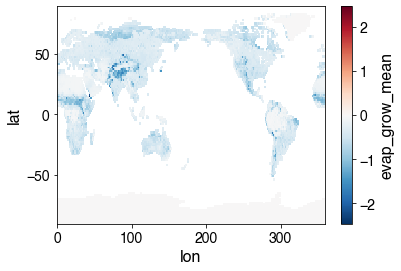

In [56]:
era5_evap_from_soil_grow_regrid.mean(dim='time').evap_grow_mean.plot()

In [66]:
%%time

recalc = True

# era5 trends for growing season data

if recalc:

    # calc era5 txx and t50p trends
    era5_tasmax_grow_max_trend = xr.Dataset()
    era5_tasmax_grow_mean_trend = xr.Dataset()
    era5_ef_grow_trend = xr.Dataset()
    era5_pr_grow_trend = xr.Dataset()
    era5_trans_grow_trend = xr.Dataset()
    era5_evap_from_canopy_grow_trend = xr.Dataset()
    era5_evap_from_soil_grow_trend = xr.Dataset()

    print('calc era5 txx, t50p, and ef trends')
    tmp_tasmax_grow_max_trend = np.full([era5_tasmax_grow_max_regrid.lat.values.shape[0], era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)
    tmp_tasmax_grow_mean_trend = np.full([era5_tasmax_grow_mean_regrid.lat.values.shape[0], era5_tasmax_grow_mean_regrid.lon.values.shape[0]], np.nan)
    tmp_ef_grow_trend = np.full([era5_ef_grow_regrid.lat.values.shape[0], era5_ef_grow_regrid.lon.values.shape[0]], np.nan)
    tmp_pr_grow_trend = np.full([era5_pr_grow_regrid.lat.values.shape[0], era5_pr_grow_regrid.lon.values.shape[0]], np.nan)
    tmp_trans_grow_trend = np.full([era5_trans_grow_regrid.lat.values.shape[0], era5_trans_grow_regrid.lon.values.shape[0]], np.nan)
    tmp_evap_from_canopy_grow_trend = np.full([era5_evap_from_canopy_grow_regrid.lat.values.shape[0], era5_evap_from_canopy_grow_regrid.lon.values.shape[0]], np.nan)
    tmp_evap_from_soil_grow_trend = np.full([era5_evap_from_soil_grow_regrid.lat.values.shape[0], era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)

    for xlat in range(tmp_tasmax_grow_max_trend.shape[0]):
        for ylon in range(tmp_tasmax_grow_max_trend.shape[1]):
            cur_tasmax_grow_max = era5_tasmax_grow_max_regrid.tasmax_grow_max.values[:, xlat, ylon]
            X = sm.add_constant(range(1981, 2014+1))
            mdl = sm.OLS(cur_tasmax_grow_max, X).fit()
            tmp_tasmax_grow_max_trend[xlat, ylon] = mdl.params[1]*10

            cur_tasmax_grow_mean = era5_tasmax_grow_mean_regrid.tasmax_grow_mean.values[:, xlat, ylon]
            X = sm.add_constant(range(1981, 2014+1))
            mdl = sm.OLS(cur_tasmax_grow_mean, X).fit()
            tmp_tasmax_grow_mean_trend[xlat, ylon] = mdl.params[1]*10
            
            cur_ef_grow = era5_ef_grow_regrid.ef_grow.values[:, xlat, ylon]
            X = sm.add_constant(range(1981, 2014+1))
            mdl = sm.OLS(cur_ef_grow, X).fit()
            tmp_ef_grow_trend[xlat, ylon] = mdl.params[1]*10
            
            cur_pr_grow = era5_pr_grow_regrid.pr_grow_mean.values[:, xlat, ylon]
            X = sm.add_constant(range(1981, 2014+1))
            mdl = sm.OLS(cur_pr_grow, X).fit()
            tmp_pr_grow_trend[xlat, ylon] = mdl.params[1]*10
            
            cur_trans_grow = era5_trans_grow_regrid.trans_grow_mean.values[:, xlat, ylon]
            X = sm.add_constant(range(1982, 2014+1))
            mdl = sm.OLS(cur_trans_grow, X).fit()
            tmp_trans_grow_trend[xlat, ylon] = -mdl.params[1]*10
            
            cur_evap_from_canopy_grow = era5_evap_from_canopy_grow_regrid.evap_grow_mean.values[:, xlat, ylon]
            X = sm.add_constant(range(1982, 2014+1))
            mdl = sm.OLS(cur_evap_from_canopy_grow, X).fit()
            tmp_evap_from_canopy_grow_trend[xlat, ylon] = -mdl.params[1]*10
            
            cur_evap_from_soil_grow = era5_evap_from_soil_grow_regrid.evap_grow_mean.values[:, xlat, ylon]
            X = sm.add_constant(range(1982, 2014+1))
            mdl = sm.OLS(cur_evap_from_soil_grow, X).fit()
            tmp_evap_from_soil_grow_trend[xlat, ylon] = -mdl.params[1]*10
            
            
            

    era5_tasmax_grow_max_trend['tasmax_grow_max_trend'] = xr.DataArray(data   = tmp_tasmax_grow_max_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_tasmax_grow_max_regrid.lat, 'lon':era5_tasmax_grow_max_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
    era5_tasmax_grow_max_trend.to_netcdf('era5/growing_season/era5_tasmax_grow_max_trend_%s.nc'%region)

    era5_tasmax_grow_mean_trend['tasmax_grow_mean_trend'] = xr.DataArray(data   = tmp_tasmax_grow_mean_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_tasmax_grow_mean_regrid.lat, 'lon':era5_tasmax_grow_mean_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
    era5_tasmax_grow_mean_trend.to_netcdf('era5/growing_season/era5_tasmax_grow_mean_trend_%s.nc'%region)
    
    era5_ef_grow_trend['ef_grow_trend'] = xr.DataArray(data   = tmp_ef_grow_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_ef_grow_regrid.lat, 'lon':era5_ef_grow_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
    era5_ef_grow_trend.to_netcdf('era5/growing_season/era5_ef_grow_trend_%s.nc'%region)
    
    era5_pr_grow_trend['pr_grow_trend'] = xr.DataArray(data   = tmp_pr_grow_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_pr_grow_regrid.lat, 'lon':era5_pr_grow_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
    era5_pr_grow_trend.to_netcdf('era5/growing_season/era5_pr_grow_trend_%s.nc'%region)
    
    era5_trans_grow_trend['trans_grow_trend'] = xr.DataArray(data   = tmp_trans_grow_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_trans_grow_regrid.lat, 'lon':era5_trans_grow_regrid.lon},
                      attrs  = {'units'     : 'mm/yr/decade'
                        })
    era5_trans_grow_trend.to_netcdf('era5/growing_season/era5_trans_grow_trend_%s.nc'%region)
    
    era5_evap_from_canopy_grow_trend['evap_from_canopy_grow_trend'] = xr.DataArray(data   = tmp_evap_from_canopy_grow_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_evap_from_canopy_grow_regrid.lat, 'lon':era5_evap_from_canopy_grow_regrid.lon},
                      attrs  = {'units'     : 'mm/yr/decade'
                        })
    era5_evap_from_canopy_grow_trend.to_netcdf('era5/growing_season/era5_evap_from_canopy_grow_trend_%s.nc'%region)
    
    era5_evap_from_soil_grow_trend['evap_from_soil_grow_trend'] = xr.DataArray(data   = tmp_evap_from_soil_grow_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_evap_from_soil_grow_regrid.lat, 'lon':era5_evap_from_soil_grow_regrid.lon},
                      attrs  = {'units'     : 'mm/yr/decade'
                        })
    era5_evap_from_soil_grow_trend.to_netcdf('era5/growing_season/era5_evap_from_soil_grow_trend_%s.nc'%region)
else:
    era5_tasmax_grow_max_trend = xr.open_dataset('era5/growing_season/era5_tasmax_grow_max_trend_%s.nc'%region)
    era5_tasmax_grow_mean_trend = xr.open_dataset('era5/growing_season/era5_tasmax_grow_mean_trend_%s.nc'%region)    
    era5_ef_grow_trend = xr.open_dataset('era5/growing_season/era5_ef_grow_trend_%s.nc'%region)
    era5_pr_grow_trend = xr.open_dataset('era5/growing_season/era5_pr_grow_trend_%s.nc'%region)
    era5_trans_grow_trend = xr.open_dataset('era5/growing_season/era5_trans_grow_trend_%s.nc'%region)
    era5_evap_from_canopy_grow_trend = xr.open_dataset('era5/growing_season/era5_evap_from_canopy_grow_trend_%s.nc'%region)
    era5_evap_from_soil_grow_trend = xr.open_dataset('era5/growing_season/era5_evap_from_soil_grow_trend_%s.nc'%region)




calc era5 txx, t50p, and ef trends
CPU times: user 1min 45s, sys: 0 ns, total: 1min 45s
Wall time: 1min 45s


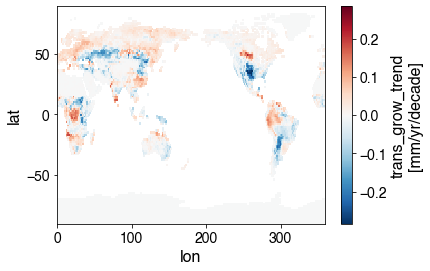

In [67]:
era5_trans_grow_trend.trans_grow_trend.plot()

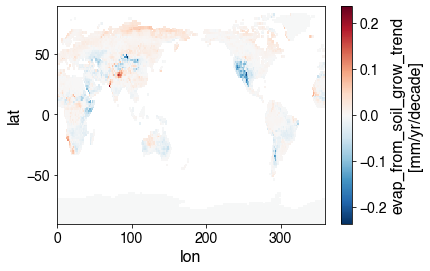

In [68]:
era5_evap_from_soil_grow_trend.evap_from_soil_grow_trend.plot()

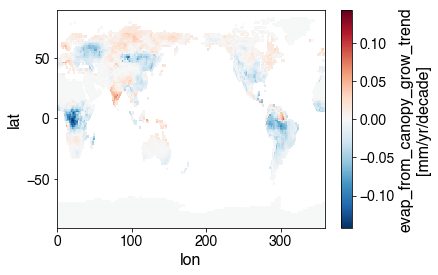

In [69]:
era5_evap_from_canopy_grow_trend.evap_from_canopy_grow_trend.plot()

In [44]:
%%time

# era5 trends over whole year

recalc = False

if recalc:
    # calc era5 txx and t50p trends
    era5_tasmax_max_trend = xr.Dataset()
    era5_tasmax_monthly_max_trend = xr.Dataset()
    era5_tasmax_mean_trend = xr.Dataset()

    era5_tasmin_max_trend = xr.Dataset()
    era5_tasmin_mean_trend = xr.Dataset()

    print('calc era5 txx and t50p trends')
    tmp_tasmax_max_trend = np.full([era5_tasmax_max_regrid.lat.values.shape[0], era5_tasmax_max_regrid.lon.values.shape[0]], np.nan)
    tmp_tasmax_monthly_max_trend = np.full([12, era5_tasmax_max_regrid.lat.values.shape[0], era5_tasmax_max_regrid.lon.values.shape[0]], np.nan)
    tmp_tasmax_mean_trend = np.full([era5_tasmax_mean_regrid.lat.values.shape[0], era5_tasmax_mean_regrid.lon.values.shape[0]], np.nan)

    # tmp_tasmin_max_trend = np.full([era5_tasmin_max_regrid.lat.values.shape[0], era5_tasmin_max_regrid.lon.values.shape[0]], np.nan)
    # tmp_tasmin_mean_trend = np.full([era5_tasmin_mean_regrid.lat.values.shape[0], era5_tasmin_mean_regrid.lon.values.shape[0]], np.nan)

    monthly_groups = era5_tasmax_monthly_max_regrid.groupby('time.month').groups

    for xlat in range(tmp_tasmax_max_trend.shape[0]):
        for ylon in range(tmp_tasmax_max_trend.shape[1]):
            cur_tasmax_max = era5_tasmax_max_regrid.tasmax_max.values[:, xlat, ylon]
            X = sm.add_constant(range(1981, 2014+1))
            mdl = sm.OLS(cur_tasmax_max, X).fit()
            tmp_tasmax_max_trend[xlat, ylon] = mdl.params[1]*10

            cur_tasmax_mean = era5_tasmax_mean_regrid.tasmax_mean.values[:, xlat, ylon]
            X = sm.add_constant(range(1981, 2014+1))
            mdl = sm.OLS(cur_tasmax_mean, X).fit()
            tmp_tasmax_mean_trend[xlat, ylon] = mdl.params[1]*10

    #         cur_tasmin_max = era5_tasmin_max_regrid.tasmin_max.values[:, xlat, ylon]
    #         X = sm.add_constant(range(1981, 2014+1))
    #         mdl = sm.OLS(cur_tasmin_max, X).fit()
    #         tmp_tasmin_max_trend[xlat, ylon] = mdl.params[1]*10

    #         cur_tasmin_mean = era5_tasmin_mean_regrid.tasmin_mean.values[:, xlat, ylon]
    #         X = sm.add_constant(range(1981, 2014+1))
    #         mdl = sm.OLS(cur_tasmin_mean, X).fit()
    #         tmp_tasmin_mean_trend[xlat, ylon] = mdl.params[1]*10

            for month in range(1, 13):
                curMonthlyTx = era5_tasmax_monthly_max_regrid['tasmax_monthly_max'].values[monthly_groups[month], xlat, ylon]
                X = sm.add_constant(range(1981, 2014+1))
                mdl = sm.OLS(curMonthlyTx, X).fit()
                tmp_tasmax_monthly_max_trend[month-1, xlat, ylon] = mdl.params[1]*10

    era5_tasmax_max_trend['tasmax_max_trend'] = xr.DataArray(data   = tmp_tasmax_max_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_tasmax_max_regrid.lat, 'lon':era5_tasmax_max_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
    era5_tasmax_max_trend.to_netcdf('era5/era5_tasmax_max_trend_%s.nc'%region)

    era5_tasmax_monthly_max_trend['tasmax_monthly_max_trend'] = xr.DataArray(data   = tmp_tasmax_monthly_max_trend, 
                      dims   = ['month', 'lat', 'lon'],
                      coords = {'month':np.arange(1,13), 'lat':era5_tasmax_monthly_max_regrid.lat, 'lon':era5_tasmax_monthly_max_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
    era5_tasmax_monthly_max_trend.to_netcdf('era5/era5_tasmax_monthly_max_trend_%s.nc'%region)

    era5_tasmax_mean_trend['tasmax_mean_trend'] = xr.DataArray(data   = tmp_tasmax_mean_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_tasmax_mean_regrid.lat, 'lon':era5_tasmax_mean_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
    era5_tasmax_mean_trend.to_netcdf('era5/era5_tasmax_mean_trend_%s.nc'%region)

    era5_tasmin_max_trend['tasmin_max_trend'] = xr.DataArray(data   = tmp_tasmin_max_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_tasmin_max_regrid.lat, 'lon':era5_tasmin_max_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })

    era5_tasmin_mean_trend['tasmin_mean_trend'] = xr.DataArray(data   = tmp_tasmin_mean_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_tasmin_mean_regrid.lat, 'lon':era5_tasmin_mean_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
else:
    era5_tasmax_max_trend = xr.open_dataset('era5/era5_tasmax_max_trend_%s.nc'%region)
    era5_tasmax_monthly_max_trend = xr.open_dataset('era5/era5_tasmax_monthly_max_trend_%s.nc'%region)
    era5_tasmax_mean_trend = xr.open_dataset('era5/era5_tasmax_mean_trend_%s.nc'%region)



CPU times: user 16.6 ms, sys: 135 µs, total: 16.8 ms
Wall time: 111 ms


In [45]:

# calculate trend bias between cmip6 and era5

recalc = True

if recalc:
    # TASMAX ANNUAL MAX
    print('tasmax annual max')
    cmip6_era5_tasmax_max_trend_bias_sig = np.full(era5_tasmax_max_trend.tasmax_max_trend.shape, np.nan)
    cmip6_era5_tasmax_max_trend_bias = np.full([len(cmip6_models), era5_tasmax_max_trend.tasmax_max_trend.shape[0], era5_tasmax_max_trend.tasmax_max_trend.shape[1]], np.nan)

    for m, model in enumerate(cmip6_models):
        cmip6_era5_tasmax_max_trend_bias[m,:,:] = cmip6_tasmax_max_trend.tasmax_max_trend.values[m,:,:] - era5_tasmax_max_trend.tasmax_max_trend.values

    for xlat in range(cmip6_era5_tasmax_max_trend_bias_sig.shape[0]):
        for ylon in range(cmip6_era5_tasmax_max_trend_bias_sig.shape[1]):
            t, p = scipy.stats.ttest_1samp(cmip6_era5_tasmax_max_trend_bias[:, xlat, ylon], 0)
            cmip6_era5_tasmax_max_trend_bias_sig[xlat, ylon] = p

    # TASMAX MONTHLY MAX
    print('tasmax monthly max')
    cmip6_era5_tasmax_monthly_max_trend_bias_sig = np.full([12, era5_tasmax_monthly_max_trend.tasmax_monthly_max_trend.shape[1], era5_tasmax_monthly_max_trend.tasmax_monthly_max_trend.shape[2]], np.nan)
    cmip6_era5_tasmax_monthly_max_trend_bias = np.full([12, len(cmip6_models), era5_tasmax_monthly_max_trend.tasmax_monthly_max_trend.shape[1], era5_tasmax_monthly_max_trend.tasmax_monthly_max_trend.shape[2]], np.nan)

    for m, model in enumerate(cmip6_models):
        for month in range(12):
            cmip6_era5_tasmax_monthly_max_trend_bias[month,m,:,:] = cmip6_tasmax_monthly_max_trend.tasmax_monthly_max_trend.values[m,month,:,:] - era5_tasmax_monthly_max_trend.tasmax_monthly_max_trend.values[month,:,:]

    for month in range(12):
        print('month %d'%month)
        for xlat in range(cmip6_era5_tasmax_monthly_max_trend_bias_sig.shape[1]):
            for ylon in range(cmip6_era5_tasmax_monthly_max_trend_bias_sig.shape[2]):
                t, p = scipy.stats.ttest_1samp(cmip6_era5_tasmax_monthly_max_trend_bias[month,:, xlat, ylon], 0)
                cmip6_era5_tasmax_monthly_max_trend_bias_sig[month,xlat, ylon] = p


    # TASMAX GROWING SEASON MAX
    print('tasmax growing season max')
    cmip6_era5_tasmax_grow_max_trend_bias_sig = np.full(era5_tasmax_grow_max_trend.tasmax_grow_max_trend.shape, np.nan)
    cmip6_era5_tasmax_grow_max_trend_bias = np.full([cmip6_tasmax_grow_max_trend.model.size, era5_tasmax_grow_max_trend.tasmax_grow_max_trend.shape[0], era5_tasmax_grow_max_trend.tasmax_grow_max_trend.shape[1]], np.nan)

    for m, model in enumerate(cmip6_tasmax_grow_max_trend.model):
        cmip6_era5_tasmax_grow_max_trend_bias[m,:,:] = cmip6_tasmax_grow_max_trend.tasmax_grow_max_trend.values[m,:,:] - era5_tasmax_grow_max_trend.tasmax_grow_max_trend.values

    for xlat in range(cmip6_era5_tasmax_grow_max_trend_bias_sig.shape[0]):
        for ylon in range(cmip6_era5_tasmax_grow_max_trend_bias_sig.shape[1]):
            t, p = scipy.stats.ttest_1samp(cmip6_era5_tasmax_grow_max_trend_bias[:, xlat, ylon], 0)
            cmip6_era5_tasmax_grow_max_trend_bias_sig[xlat, ylon] = p

    # TASMAX GROWING SEASON MEAN
    print('tasmax growing season mean')
    cmip6_era5_tasmax_grow_mean_trend_bias_sig = np.full(era5_tasmax_grow_mean_trend.tasmax_grow_mean_trend.shape, np.nan)
    cmip6_era5_tasmax_grow_mean_trend_bias = np.full([cmip6_tasmax_grow_max_trend.model.size, era5_tasmax_grow_mean_trend.tasmax_grow_mean_trend.shape[0], era5_tasmax_grow_mean_trend.tasmax_grow_mean_trend.shape[1]], np.nan)

    for m, model in enumerate(cmip6_tasmax_grow_max_trend.model):
        cmip6_era5_tasmax_grow_mean_trend_bias[m,:,:] = cmip6_tasmax_grow_mean_trend.tasmax_grow_mean_trend.values[m,:,:] - era5_tasmax_grow_mean_trend.tasmax_grow_mean_trend.values

    for xlat in range(cmip6_era5_tasmax_grow_mean_trend_bias_sig.shape[0]):
        for ylon in range(cmip6_era5_tasmax_grow_mean_trend_bias_sig.shape[1]):
            t, p = scipy.stats.ttest_1samp(cmip6_era5_tasmax_grow_mean_trend_bias[:, xlat, ylon], 0)
            cmip6_era5_tasmax_grow_mean_trend_bias_sig[xlat, ylon] = p


    # EF GROWING SEASON MEAN
    print('ef growing season mean')
    cmip6_era5_ef_grow_trend_bias_sig = np.full(era5_ef_grow_trend.ef_grow_trend.shape, np.nan)
    cmip6_era5_ef_grow_trend_bias = np.full([cmip6_ef_grow_trend.model.size, era5_ef_grow_trend.ef_grow_trend.shape[0], era5_ef_grow_trend.ef_grow_trend.shape[1]], np.nan)

    for m, model in enumerate(cmip6_ef_grow_trend.model):
        cmip6_era5_ef_grow_trend_bias[m,:,:] = cmip6_ef_grow_trend.grow_ef.values[m,:,:] - era5_ef_grow_trend.ef_grow_trend.values

    for xlat in range(cmip6_era5_ef_grow_trend_bias_sig.shape[0]):
        for ylon in range(cmip6_era5_ef_grow_trend_bias_sig.shape[1]):
            t, p = scipy.stats.ttest_1samp(cmip6_era5_ef_grow_trend_bias[:, xlat, ylon], 0)
            cmip6_era5_ef_grow_trend_bias_sig[xlat, ylon] = p
            
            
    # PR GROWING SEASON MEAN
    print('pr growing season mean')
    cmip6_era5_pr_grow_trend_bias_sig = np.full(era5_pr_grow_trend.pr_grow_trend.shape, np.nan)
    cmip6_era5_pr_grow_trend_bias = np.full([cmip6_pr_grow_trend.model.size, era5_pr_grow_trend.pr_grow_trend.shape[0], era5_pr_grow_trend.pr_grow_trend.shape[1]], np.nan)

    for m, model in enumerate(cmip6_pr_grow_trend.model):
        cmip6_era5_pr_grow_trend_bias[m,:,:] = cmip6_pr_grow_trend.pr_grow_mean.values[m,:,:] - era5_pr_grow_trend.pr_grow_trend.values

    for xlat in range(cmip6_era5_pr_grow_trend_bias_sig.shape[0]):
        for ylon in range(cmip6_era5_pr_grow_trend_bias_sig.shape[1]):
            t, p = scipy.stats.ttest_1samp(cmip6_era5_pr_grow_trend_bias[:, xlat, ylon], 0)
            cmip6_era5_pr_grow_trend_bias_sig[xlat, ylon] = p

            
    cmip6_era5_biases = {'cmip6_era5_tasmax_max_trend_bias':cmip6_era5_tasmax_max_trend_bias,
                            'cmip6_era5_tasmax_max_trend_bias_sig':cmip6_era5_tasmax_max_trend_bias_sig,
                        'cmip6_era5_tasmax_monthly_max_trend_bias':cmip6_era5_tasmax_monthly_max_trend_bias,
                        'cmip6_era5_tasmax_monthly_max_trend_bias_sig':cmip6_era5_tasmax_monthly_max_trend_bias_sig,
                         'cmip6_era5_tasmax_grow_max_trend_bias':cmip6_era5_tasmax_grow_max_trend_bias,
                         'cmip6_era5_tasmax_grow_max_trend_bias_sig':cmip6_era5_tasmax_grow_max_trend_bias_sig,
                         'cmip6_era5_tasmax_grow_mean_trend_bias':cmip6_era5_tasmax_grow_mean_trend_bias,
                         'cmip6_era5_tasmax_grow_mean_trend_bias_sig':cmip6_era5_tasmax_grow_mean_trend_bias_sig,
                         'cmip6_era5_ef_grow_trend_bias':cmip6_era5_ef_grow_trend_bias,
                         'cmip6_era5_ef_grow_trend_bias_sig':cmip6_era5_ef_grow_trend_bias_sig,
                         'cmip6_era5_pr_grow_trend_bias':cmip6_era5_pr_grow_trend_bias,
                         'cmip6_era5_pr_grow_trend_bias_sig':cmip6_era5_pr_grow_trend_bias_sig}
    
    with open('cmip6_output/bias/cmip6-era5-bias.dat', 'wb') as f:
        pickle.dump(cmip6_era5_biases, f)


tasmax annual max
tasmax monthly max
month 0
month 1
month 2
month 3
month 4
month 5
month 6
month 7
month 8
month 9
month 10
month 11
tasmax growing season max
tasmax growing season mean
ef growing season mean
pr growing season mean


In [46]:
# load pre-calculated bias by year

monthly_groups = cmip6_tasmax_monthly_max.groupby('time.month').groups

yearly_tasmax_max_bias = np.full([len(cmip6_models), era5_tasmax_max_regrid.time.values.shape[0], \
                                  era5_tasmax_max_regrid.lat.values.shape[0], \
                                  era5_tasmax_max_regrid.lon.values.shape[0]], np.nan)
yearly_tasmax_monthly_max_bias = np.full([len(cmip6_models), 12, len(monthly_groups[1]), \
                                  cmip6_tasmax_monthly_max.lat.values.shape[0], \
                                  cmip6_tasmax_monthly_max.lon.values.shape[0]], np.nan)
yearly_tasmax_mean_bias = np.full([len(cmip6_models), era5_tasmax_mean_regrid.time.values.shape[0], \
                                   era5_tasmax_mean_regrid.lat.values.shape[0], \
                                   era5_tasmax_mean_regrid.lon.values.shape[0]], np.nan)

yearly_tasmax_grow_max_bias = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)
yearly_tasmax_grow_mean_bias = np.full([len(cmip6_models), era5_tasmax_grow_mean_regrid.time.values.shape[0], \
                                   era5_tasmax_grow_mean_regrid.lat.values.shape[0], \
                                   era5_tasmax_grow_mean_regrid.lon.values.shape[0]], np.nan)
yearly_ef_grow_bias = np.full([len(cmip6_models), era5_ef_grow_regrid.time.values.shape[0], \
                                   era5_ef_grow_regrid.lat.values.shape[0], \
                                   era5_ef_grow_regrid.lon.values.shape[0]], np.nan)

yearly_pr_grow_bias = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)
yearly_pr_grow_bias_rel = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)

for m, model in enumerate(cmip6_models):
    print('loading yearly bias for %s'%model)
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-max-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_max_bias[m, :, :, :] = pickle.load(f)
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-monthly-max-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_monthly_max_bias[m, :, :, :, :] = pickle.load(f)
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-mean-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_mean_bias[m, :, :, :] = pickle.load(f)
        
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-grow-max-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_grow_max_bias[m, :, :, :] = pickle.load(f)
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-grow-mean-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_grow_mean_bias[m, :, :, :] = pickle.load(f)
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-ef-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-ef-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_ef_grow_bias[m, :, :, :] = pickle.load(f)
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-pr-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-pr-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_pr_grow_bias[m, :, :, :] = pickle.load(f)
            for y in range(yearly_pr_grow_bias.shape[1]):
                yearly_pr_grow_bias_rel[m, y, :, :] = yearly_pr_grow_bias[m, y, :, :]/np.nanmean(era5_pr_grow_regrid.pr_grow_mean, axis=0)
        


loading yearly bias for access-cm2
loading yearly bias for access-esm1-5
loading yearly bias for awi-cm-1-1-mr
loading yearly bias for bcc-csm2-mr
loading yearly bias for bcc-esm1
loading yearly bias for canesm5
loading yearly bias for ec-earth3
loading yearly bias for gfdl-cm4
loading yearly bias for gfdl-esm4
loading yearly bias for giss-e2-1-g
loading yearly bias for kace-1-0-g
loading yearly bias for fgoals-g3
loading yearly bias for inm-cm5-0
loading yearly bias for ipsl-cm6a-lr
loading yearly bias for miroc6
loading yearly bias for mpi-esm1-2-hr
loading yearly bias for mpi-esm1-2-lr
loading yearly bias for mri-esm2-0
loading yearly bias for noresm2-lm
loading yearly bias for noresm2-mm
loading yearly bias for sam0-unicon


In [234]:
# load deepak data

recalc = False

if not os.path.isfile('deepak_regions/deepak_maize_%s.nc'%region) or recalc:
    
    maize_yield_deepak_ds = xr.Dataset()
    soy_yield_deepak_ds = xr.Dataset()
    wheat_yield_deepak_ds = xr.Dataset()

    for y, year in enumerate(range(1979, 2013+1)):
        print('processing deepak for %d...'%year)
        cur_maize_yield_deepak_ds = xr.open_dataset('%s/Maize_yield_1970_2013/Maize_areaweightedyield_%d_ver12b.nc'%(dirDeepak, year))

        lonvals = cur_maize_yield_deepak_ds['longitude'].values
        lonvals[lonvals < 0] = 360+lonvals[lonvals < 0]
        cur_maize_yield_deepak_ds['longitude'] = lonvals

        latvals = cur_maize_yield_deepak_ds['latitude'].values
        cur_maize_yield_deepak_ds['latitude'] = latvals

        cur_maize_yield_deepak_ds = cur_maize_yield_deepak_ds.rename(latitude='lat', longitude='lon')

        cur_maize_yield_deepak_ds.load()

        regridder = xe.Regridder(cur_maize_yield_deepak_ds, regridMesh, 'bilinear')
        regridder.clean_weight_file()
        cur_maize_yield_deepak_ds_regrid = regridder(cur_maize_yield_deepak_ds.Data)

        tempDs_maize_yield = xr.Dataset()
        tempDs_maize_yield['maize_yield'] = xr.DataArray(data = np.squeeze(cur_maize_yield_deepak_ds_regrid.values, axis=1), 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                              attrs  = {'units'     : 't/ha'
                                })

        if y == 0:
            maize_yield_deepak_ds = tempDs_maize_yield
        else:
            maize_yield_deepak_ds = xr.concat([maize_yield_deepak_ds, tempDs_maize_yield], dim='time')
        
        
        
        cur_soy_yield_deepak_ds = xr.open_dataset('%s/Soy_yield_1970_2013/Soybean_areaweightedyield_%d_ver12b.nc'%(dirDeepak, year))

        lonvals = cur_soy_yield_deepak_ds['longitude'].values
        lonvals[lonvals < 0] = 360+lonvals[lonvals < 0]
        cur_soy_yield_deepak_ds['longitude'] = lonvals

        latvals = cur_soy_yield_deepak_ds['latitude'].values
        cur_soy_yield_deepak_ds['latitude'] = latvals

        cur_soy_yield_deepak_ds = cur_soy_yield_deepak_ds.rename(latitude='lat', longitude='lon')

        cur_soy_yield_deepak_ds.load()

        regridder = xe.Regridder(cur_soy_yield_deepak_ds, regridMesh, 'bilinear')
        regridder.clean_weight_file()
        cur_soy_yield_deepak_ds_regrid = regridder(cur_soy_yield_deepak_ds.Data)

        tempDs_soy_yield = xr.Dataset()
        tempDs_soy_yield['soy_yield'] = xr.DataArray(data = np.squeeze(cur_soy_yield_deepak_ds_regrid.values, axis=1), 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                              attrs  = {'units'     : 't/ha'
                                })

        if y == 0:
            soy_yield_deepak_ds = tempDs_soy_yield
        else:
            soy_yield_deepak_ds = xr.concat([soy_yield_deepak_ds, tempDs_soy_yield], dim='time')
        
        
        
        cur_wheat_yield_deepak_ds = xr.open_dataset('%s/Wheat_yield_1970_2013/Wheat_areaweightedyield_%d_ver12b.nc'%(dirDeepak, year))

        lonvals = cur_wheat_yield_deepak_ds['longitude'].values
        lonvals[lonvals < 0] = 360+lonvals[lonvals < 0]
        cur_wheat_yield_deepak_ds['longitude'] = lonvals

        latvals = cur_wheat_yield_deepak_ds['latitude'].values
        cur_wheat_yield_deepak_ds['latitude'] = latvals

        cur_wheat_yield_deepak_ds = cur_wheat_yield_deepak_ds.rename(latitude='lat', longitude='lon')

        cur_wheat_yield_deepak_ds.load()

        regridder = xe.Regridder(cur_wheat_yield_deepak_ds, regridMesh, 'bilinear')
        regridder.clean_weight_file()
        cur_wheat_yield_deepak_ds_regrid = regridder(cur_wheat_yield_deepak_ds.Data)

        tempDs_wheat_yield = xr.Dataset()
        tempDs_wheat_yield['wheat_yield'] = xr.DataArray(data = np.squeeze(cur_wheat_yield_deepak_ds_regrid.values, axis=1), 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                              attrs  = {'units'     : 't/ha'
                                })

        if y == 0:
            wheat_yield_deepak_ds = tempDs_wheat_yield
        else:
            wheat_yield_deepak_ds = xr.concat([wheat_yield_deepak_ds, tempDs_wheat_yield], dim='time')
            
    maize_yield_deepak_ds.to_netcdf('deepak_regions/deepak_maize_%s.nc'%region)
    soy_yield_deepak_ds.to_netcdf('deepak_regions/deepak_soy_%s.nc'%region)
    wheat_yield_deepak_ds.to_netcdf('deepak_regions/deepak_wheat_%s.nc'%region)
else:
    maize_yield_deepak_ds = xr.open_dataset('deepak_regions/deepak_maize_%s.nc'%region)
    soy_yield_deepak_ds = xr.open_dataset('deepak_regions/deepak_soy_%s.nc'%region)
    wheat_yield_deepak_ds = xr.open_dataset('deepak_regions/deepak_wheat_%s.nc'%region)